In [9]:
# 필요한 라이브러리 임포트
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# E5 임베딩 생성 클래스
class E5Embedder:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-large")
        self.model = AutoModel.from_pretrained("intfloat/e5-large")

    def get_embedding(self, text):
        """텍스트를 E5 임베딩 벡터로 변환"""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach()


In [12]:
class EmotionClassifier:
    def __init__(self, model_path="monologg/kobert", num_labels=7, device=None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model.to(self.device)

        # 감정 매핑
        self.label_to_emotion = {
            0: "중립",
            1: "놀람",
            2: "분노",
            3: "슬픔",
            4: "행복",
            5: "혐오",
            6: "공포"
        }

    def load_model(self, model_file):
        """학습된 KoBERT 모델 불러오기"""
        state_dict = torch.load(model_file, map_location=self.device)
        self.model.load_state_dict(state_dict)

    def predict_emotion(self, text):
        """감정 분류 및 예측"""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            predicted_label = outputs.logits.argmax(dim=1).item()
        return self.label_to_emotion[predicted_label]


In [13]:
# 트로트 데이터 로드
song_data_path = "trot_embeddings_emotion.pkl"  # 저장된 피클 파일 경로
df = pd.read_pickle(song_data_path)

# 데이터 확인
print("데이터프레임 구조:")
print(df.head())


데이터프레임 구조:
              title          artist  \
0             진정인가요             정서주   
1    멘토링 (Feat. 곽범)             이지요   
2            사랑의삼매경  누나둘 (Nunadool)   
3  유리꽃 (Cover Ver.)             김준영   
4           제목은 당신꽃              동후   

                                      cleaned_lyrics  \
0  미련없다 그 말이 진정인가요 냉정했던 그 마음이 진정인가요 바닷가를 거닐며 수놓았던...   
1  그댄 나의 멘토야 나는 당신의 에너지 즐거운 하루되세요 행복한 기분 너무 좋아요 그...   
2  삼매경에 빠져요 사랑에빠져요 삼매경에 빠져요 사랑의삼매경에 빠져요 흠뻑 빠져버린 내...   
3  유리꽃처럼 입술만 훔치고 가버린 그날 그 카페에 지울 수 없는 너의 향기가 연기처럼...   
4  가로등에 꽃이 피네요 그대와 함께 거닐 때 수줍어하던 그 사랑에 이름 모를 꽃이 피...   

                                           embedding emotion  
0  [[tensor(-0.2948), tensor(-0.7847), tensor(0.6...      슬픔  
1  [[tensor(-0.6234), tensor(-0.9389), tensor(0.8...      행복  
2  [[tensor(-0.4987), tensor(-1.0133), tensor(0.5...      슬픔  
3  [[tensor(-0.5342), tensor(-0.9054), tensor(0.6...      슬픔  
4  [[tensor(-0.3140), tensor(-1.0779), tensor(0.8...      행복  


In [14]:
# 사용자 입력 텍스트
user_input = "오늘은 정말 행복한 하루였어! 삼겹살이 너무 맛있었다."

# KoBERT 기반 감정 분류 모델 초기화 및 학습된 가중치 로드
emotion_model_path = "new_data_test.pth"  # 학습된 모델 경로
emotion_classifier = EmotionClassifier()
emotion_classifier.load_model(emotion_model_path)

# E5 임베딩 모델 초기화
embedder = E5Embedder()

# 사용자 입력 텍스트의 감정 예측 및 임베딩 생성
predicted_emotion = emotion_classifier.predict_emotion(user_input)
diary_embedding = embedder.get_embedding(user_input)

print(f"입력 텍스트: {user_input}")
print(f"예측된 감정: {predicted_emotion}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


입력 텍스트: 오늘은 정말 행복한 하루였어! 삼겹살이 너무 맛있었다.
예측된 감정: 행복


In [22]:
# 코사인 유사도 계산 함수 정의
def calculate_similarity(diary_embedding, song_embeddings):
    """입력 텍스트와 노래 가사의 코사인 유사도를 계산"""
    similarities = []
    for idx, song_embedding in enumerate(song_embeddings):
        similarity = torch.nn.functional.cosine_similarity(
            diary_embedding.squeeze(), song_embedding.squeeze(), dim=0
        ).item()
        similarities.append(similarity)
    return similarities

# 노래 가사의 임베딩 추출 및 코사인 유사도 계산
song_embeddings = df['embedding'].tolist()
similarities = calculate_similarity(diary_embedding, song_embeddings)

# 데이터프레임에 유사도 추가
df['similarity'] = similarities

# 감정이 동일한 노래 필터링 및 정렬
filtered_df = df[df['emotion'] == predicted_emotion].sort_values(by='similarity', ascending=False)

# 상위 5개 노래 출력
top_songs = filtered_df.head(5)
print("\n--- 추천 결과 ---")
print(top_songs[['title', 'artist', 'similarity']])



--- 추천 결과 ---
                  title artist  similarity
7             그리고 별이 되어    안송화    0.905808
331  오매좋은거 (Cover Ver.)     지애    0.904685
182                 수선화    수선아    0.903237
324         계덕님 수레를 끄신다    이계덕    0.897261
214                인생열차    김용택    0.896605


C:\Users\user\AppData\Local\Temp\ipykernel_29164\315545124.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_songs['title'], y=top_songs['similarity'], palette="viridis")


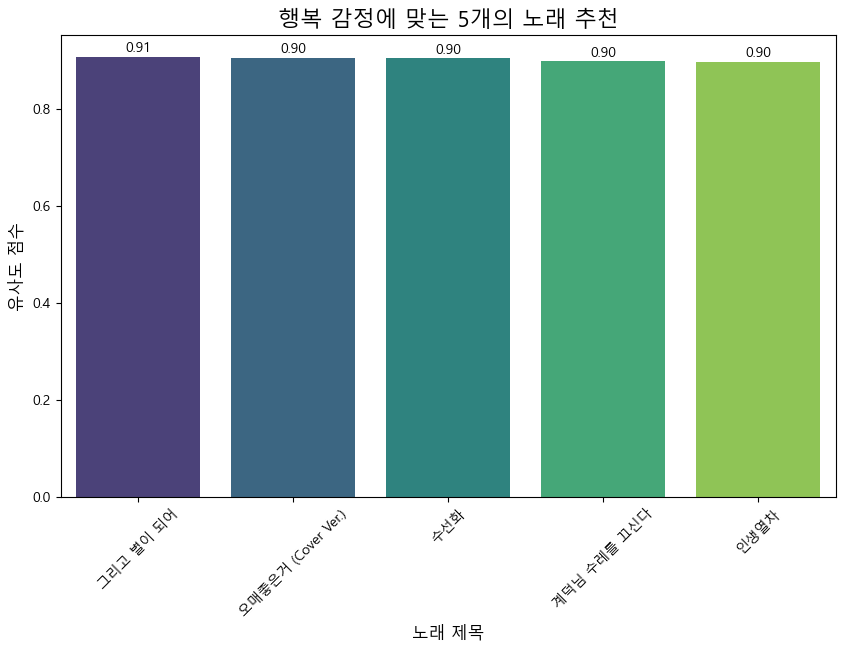

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 환경에서 Malgun Gothic 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 시각화: 유사도 분포 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x=top_songs['title'], y=top_songs['similarity'], palette="viridis")

# 그래프 제목 및 축 레이블 설정
plt.title(f"{predicted_emotion} 감정에 맞는 5개의 노래 추천", fontsize=16)
plt.xlabel("노래 제목", fontsize=12)
plt.ylabel("유사도 점수", fontsize=12)
plt.xticks(rotation=45)

# 각 바 위에 유사도 점수 표시
for index, value in enumerate(top_songs['similarity']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# 그래프 출력
plt.show()

In [28]:
df[df['emotion'] == '행복'].sort_values(by='similarity', ascending=False).tail(10)

,title,artist,cleaned_lyrics,embedding,emotion,similarity
108,그리운 사람아,참사랑,꽃피는 봄날에 꽃향기 마시며 당신과 걸어가고 싶어요 추억의 거리에서 사랑했지만 세월...,"[[tensor(-0.6794), tensor(-1.2301), tensor(0.4...",행복,0.846984
5,백세인생 살아보세,준카,복 들어온다 복들어온다 황금대박이 들어온다 대박잡아서 사랑찾고 대박잡아서 행복찾아 ...,"[[tensor(-0.2806), tensor(-1.1092), tensor(0.5...",행복,0.846671
16,나는유투브다,P.K,모든게 열려있는 유투브세상 모든게 들어있는 유투브세상 때로는 슬픈것도 알게해주고 때...,"[[tensor(-0.2404), tensor(-0.7993), tensor(0.2...",행복,0.846467
263,보름아,박민수,보름아 둥근 대보름아 보름아 우리 대보름아 달아 달아 밝은 달아 이태백이 놀던 달아...,"[[tensor(-0.4887), tensor(-1.3839), tensor(0.5...",행복,0.846149
145,너에게 건넨 사랑의 초콜릿,신선미,달콤한 사랑을 전하는 밤 너에게 건넨 초콜릿 한 알 맘 속에 퍼지는 뜨거운 마음 눈...,"[[tensor(-0.6314), tensor(-1.0019), tensor(0.5...",행복,0.844384
58,당신의 참사랑,민은이,당신의 참사랑을 받고사는난 너무도 행복합니다 이세상 모두를 나에게 선물한 당신정말 ...,"[[tensor(0.0698), tensor(-0.9575), tensor(0.80...",행복,0.843263
150,함께아리랑,한대희,함께해요 광주아리랑 아라리요 아리아리 함께 아리랑 아라리요 아리랑 아리랑 아라리요 ...,"[[tensor(-0.5216), tensor(-0.9053), tensor(0.2...",행복,0.839830
144,하늘이 맺어준 사랑,김창아,이생명 다바쳐서 당신을 사랑합니다 당신은 내사랑 하늘이 맺어준 사랑 세상에 태어나서...,"[[tensor(-0.0846), tensor(-0.8629), tensor(0.2...",행복,0.836586
147,외교의 신 `서희`,서희,우리의 영웅 고려 장위공 서희의 외교 클라스 세 치 혀로 써낸 한 편의 역대급 스케...,"[[tensor(-0.5698), tensor(-0.3813), tensor(0.1...",행복,0.831933
294,사랑이 샤르르,장미소,당신과 내가 함께 하는 모든 시간이 소중하죠 candy처럼 달콤한 당신 눈빛에 샤르...,"[[tensor(-0.4585), tensor(-1.2407), tensor(0.6...",행복,0.831535


## 테스트 해보자

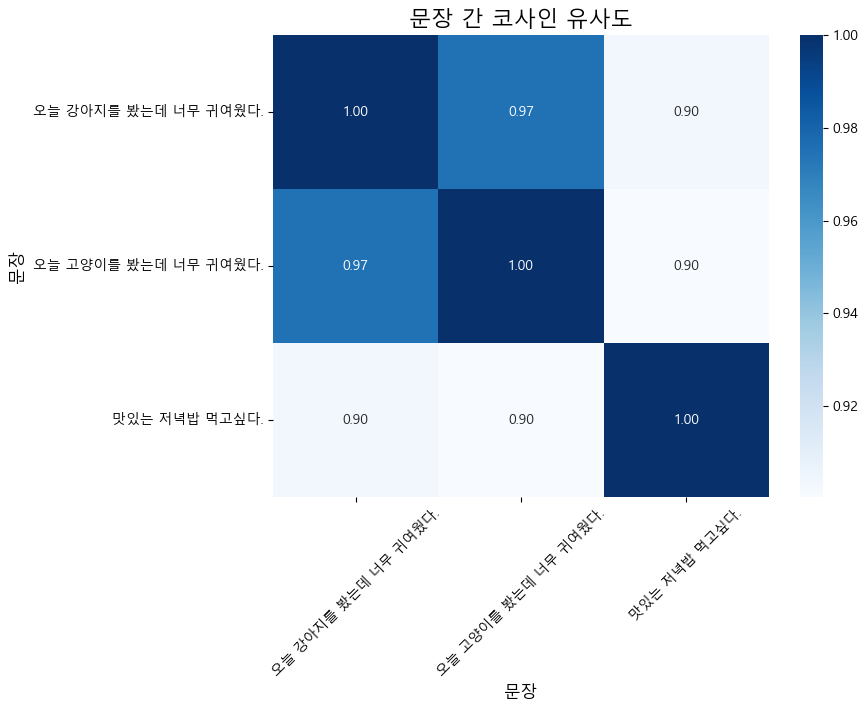

In [32]:
# 필요한 라이브러리 임포트
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# E5 임베딩 생성 클래스 정의
class E5Embedder:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-large")
        self.model = AutoModel.from_pretrained("intfloat/e5-large")

    def get_embedding(self, text):
        """텍스트를 E5 임베딩 벡터로 변환"""
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach()

# E5 임베딩 모델 초기화
embedder = E5Embedder()

# 테스트 문장 정의
sentences = [
    "오늘 강아지를 봤는데 너무 귀여웠다.",
    "오늘 고양이를 봤는데 너무 귀여웠다.",
    "맛있는 저녁밥 먹고싶다."
]

# 각 문장의 임베딩 생성
embeddings = [embedder.get_embedding(sentence) for sentence in sentences]

# 코사인 유사도 계산 함수 정의
def calculate_cosine_similarity(embedding_list):
    """임베딩 리스트 간의 코사인 유사도 계산"""
    num_sentences = len(embedding_list)
    similarity_matrix = torch.zeros((num_sentences, num_sentences))

    for i in range(num_sentences):
        for j in range(num_sentences):
            similarity_matrix[i][j] = torch.nn.functional.cosine_similarity(
                embedding_list[i].squeeze(), embedding_list[j].squeeze(), dim=0
            )
    return similarity_matrix.numpy()

# 코사인 유사도 계산
similarity_matrix = calculate_cosine_similarity(embeddings)

# 시각화를 위한 데이터 준비
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=sentences, yticklabels=sentences)
plt.title("문장 간 코사인 유사도", fontsize=16)
plt.xlabel("문장", fontsize=12)
plt.ylabel("문장", fontsize=12)
plt.xticks(rotation=45)
plt.show()
